#Exercise 1: Convolutional Autoencoder#

Train a convolutional autoencoder on MNIST, study the influence of the bottleneck size and generate some images

In [0]:
import numpy as np
np.random.seed(1)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
torch.manual_seed(1)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1)
import matplotlib.pyplot as plt

In [0]:
# Let's define some hyper-parameters
hparams = {
    'batch_size':64,
    'num_epochs':10,
    'test_batch_size':64,
    'hidden_size':128,
    'learning_rate':1e-3,
    'log_interval':100,
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

**Load Dataset**

In [4]:
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))                        
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

0it [00:00, ?it/s]

9920512it [00:01, 5113853.74it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 129690.47it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 2138910.14it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 47210.74it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


**Split data**:
We split the data in 95% for training and 5% for validation

In [5]:
#we take the size of the trainset and after that we take 5% of dataset
tvdataset_length = len(mnist_trainset)
validationset_length = int(0.05*tvdataset_length)
#we split the dataset
[trainset,validationset]=torch.utils.data.random_split(mnist_trainset,[tvdataset_length-validationset_length,validationset_length])
print('Validation dataset is :{}%'.format(100*len(validationset)/len(mnist_trainset)))
print('Training dataset is :{}%'.format(100*len(trainset)/len(mnist_trainset)))

Validation dataset is :5.0%
Training dataset is :95.0%


**Loader data**
We load the dataset with batch size 

In [0]:
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

validation_loader = torch.utils.data.DataLoader(
    validationset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
     mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)

## 2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules). ##

**Creation of the Class Autoencoder**

**Define of the Class encoder**

In [0]:
class Encoder(nn.Module):
  def __init__(self,bottleneck):
    super().__init__()
    self.bottleneck = bottleneck
    self.conv1 = nn.Sequential( 
              nn.Conv2d(1,32,5,padding=2),
              nn.BatchNorm2d(32),
              nn.MaxPool2d(2,2),
              nn.ReLU(),
              nn.Dropout(0.5))
    self.conv2 = nn.Sequential(
              nn.Conv2d(32,16,5,padding=2),
              nn.BatchNorm2d(16),
              nn.MaxPool2d(2,2),
              nn.ReLU(),
              nn.Dropout(0.5),
              nn.Flatten())
    self.fc = nn.Sequential(
              nn.Linear(16*7*7,self.bottleneck),
              nn.ReLU())
  def forward(self,x):
    x= self.conv1(x)
    x= self.conv2(x)
    x= self.fc(x)
    return x  

**Define of the class Decoder**

In [0]:
class Decoder(nn.Module):
  def __init__(self,bottleneck):
    super().__init__()
    self.bottleneck = bottleneck
    self.conv1 = nn.Sequential( 
          nn.ConvTranspose2d(64,32,14,stride=2),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Dropout(0.5))
    self.conv2 = nn.Sequential(
          nn.ConvTranspose2d(32,1,2,stride=2),
          nn.BatchNorm2d(1),
          nn.Sigmoid())
    self.fc = nn.Sequential(
          nn.Linear(self.bottleneck,64),
          nn.ReLU())
  def forward(self,x):
    x= self.fc(x)
    x= self.conv1(x.view(x.shape[0], 64, 1,1))
    x= self.conv2(x)
    return x

**Define of the class Autoencoder**

In [0]:
class Autoencoder(nn.Module):
    def __init__(self,bottleneck):
      super().__init__()
      self.bottleneck = bottleneck
      self.encoder = Encoder(self.bottleneck)
      self.decoder = Decoder(self.bottleneck)
    def forward(self,x):
      x= self.encoder(x)
      x= self.decoder(x)
      return x

**Train the Model**

Definition of the function *train epoch*. It train the weights of the model. It computes the loss of the train and it performs the backpropagation. 

In [0]:
def train_epoch(train_loader,model,optimizer,criterion,hparams):
  model.train()
  avg_loss_train = None
  avg_weight = 0.1
  for data in train_loader:
          optimizer.zero_grad()
          img, _ = data
          img = img.cuda()
          output = model(img)
          loss = criterion(output,img)
          loss.backward()
          optimizer.step()
          if avg_loss_train:
            avg_loss_train = avg_weight * loss.item() + (1 - avg_weight) * avg_loss_train
          else:
            avg_loss_train = loss.item() 
  return avg_loss_train

It is a generic fonction to evaluate the model it return the loss average and the MSE. 

In [0]:
def test_epoch(set_loader,model,hparams):
  model.eval()
  avg_loss_validation =0
  MSE = 0
  with torch.no_grad():
    for data in set_loader:
      img,_ = data
      img = img.cuda()
      output = model(img)
      val_loss = criterion(output,img)
      MSE += criterion_MSE(output,img)
      avg_loss_validation+= val_loss
  avg_loss_validation /= len(set_loader)
  MSE /= len(set_loader) 
  return avg_loss_validation,MSE

###Train of the model and evalutation of it with different bottleneck###

In [0]:
class my_dictionary(dict): 
  
    # __init__ function 
    def __init__(self): 
        self = dict() 
          
    # Function to add key:value 
    def add(self, key, value): 
        self[key] = value 

In [0]:
validation_bottleneck_MSE= my_dictionary()
test_bottleneck_MSE = my_dictionary()
validation_loss_bottleneck = my_dictionary()
train_loss_bottleneck = my_dictionary()
for bottleneck in range(1,20,4):
  model = Autoencoder(bottleneck).cuda()
  model.to(hparams['device'])
  list_MSE_validation = []
  train_loss = []
  validation_loss = []
  criterion_MSE = nn.MSELoss()
  criterion = nn.BCELoss()
  optimizer =  optim.Adam(model.parameters(), lr=hparams['learning_rate'])
  print('Bottleneck :{}'.format(bottleneck))
  
  for epoch in range(hparams['num_epochs']):
    loss_train = train_epoch(train_loader,model,optimizer,criterion,hparams)
    val_loss,MSE_validation = test_epoch(validation_loader,model,hparams)
    train_loss.append(loss_train)
    validation_loss.append(val_loss)
    list_MSE_validation.append(MSE_validation)
    print('Train epoch [{}/{}], loss:{:.4f}, validation loss = {:.4f}, MSE:{:.2f}'.format(epoch+1, hparams['num_epochs'], loss_train,val_loss,MSE_validation))
  _,test_MSE = test_epoch(test_loader,model,hparams)
  validation_loss_bottleneck.add(bottleneck,train_loss)
  validation_loss_bottleneck.add(bottleneck,validation_loss)
  validation_bottleneck_MSE.add(bottleneck,list_MSE_validation[-1].item())   
  test_bottleneck_MSE.add(bottleneck,test_MSE.item())
  print(validation_bottleneck_MSE)
  print(test_bottleneck_MSE)

Bottleneck :1
Train epoch [1/10], loss:-0.4187, validation loss = -0.4333, MSE:0.83
Train epoch [2/10], loss:-0.8741, validation loss = -0.9078, MSE:0.76
Train epoch [3/10], loss:-1.3087, validation loss = -1.3379, MSE:0.74
Train epoch [4/10], loss:-1.7178, validation loss = -1.7619, MSE:0.73
Train epoch [5/10], loss:-2.1517, validation loss = -2.1811, MSE:0.73
Train epoch [6/10], loss:-2.5726, validation loss = -2.5791, MSE:0.73
Train epoch [7/10], loss:-3.0274, validation loss = -2.9649, MSE:0.72
Train epoch [8/10], loss:-3.4456, validation loss = -3.4110, MSE:0.72
Train epoch [9/10], loss:-3.9397, validation loss = -3.8314, MSE:0.72
Train epoch [10/10], loss:-4.3060, validation loss = -4.2625, MSE:0.72
{1: 0.7189732789993286}
{1: 0.7251156568527222}
Bottleneck :5
Train epoch [1/10], loss:-0.7030, validation loss = -0.7056, MSE:0.74
Train epoch [2/10], loss:-1.3586, validation loss = -1.3689, MSE:0.64
Train epoch [3/10], loss:-1.9172, validation loss = -1.9093, MSE:0.61
Train epoch [

Plot the Loss and the MSE

In [0]:
bottleneck = 15
model = Autoencoder(bottleneck).cuda()
model.to(hparams['device'])
list_MSE_validation = []
list_MSE_test = []
train_loss = []
validation_loss = []
list_test_loss = []
criterion_MSE = nn.MSELoss()
criterion = nn.BCELoss()
optimizer =  optim.Adam(model.parameters(), lr=hparams['learning_rate'])
for epoch in range(hparams['num_epochs']):
  loss_train = train_epoch(train_loader,model,optimizer,criterion,hparams)
  val_loss,MSE_validation = test_epoch(validation_loader,model,hparams)
  test_loss,MSE_test = test_epoch(test_loader,model,hparams)
  train_loss.append(loss_train)
  validation_loss.append(val_loss)
  list_test_loss.append(test_loss)
  list_MSE_validation.append(MSE_validation)
  list_MSE_test.append(MSE_test)
  print('Train epoch [{}/{}], loss:{:.4f}, validation loss = {:.4f}, MSE:{:.2f}'
  .format(epoch+1, hparams['num_epochs'], loss_train,val_loss,MSE_validation))


Train epoch [1/10], loss:-0.8541, validation loss = -0.8561, MSE:0.70
Train epoch [2/10], loss:-1.5248, validation loss = -1.5130, MSE:0.60
Train epoch [3/10], loss:-2.1280, validation loss = -2.1432, MSE:0.56
Train epoch [4/10], loss:-2.7421, validation loss = -2.7241, MSE:0.55
Train epoch [5/10], loss:-3.3477, validation loss = -3.3362, MSE:0.54
Train epoch [6/10], loss:-3.9677, validation loss = -3.8805, MSE:0.54
Train epoch [7/10], loss:-4.5866, validation loss = -4.5201, MSE:0.54
Train epoch [8/10], loss:-5.1686, validation loss = -5.0974, MSE:0.54
Train epoch [9/10], loss:-5.7250, validation loss = -5.7878, MSE:0.53
Train epoch [10/10], loss:-6.3062, validation loss = -6.3988, MSE:0.53


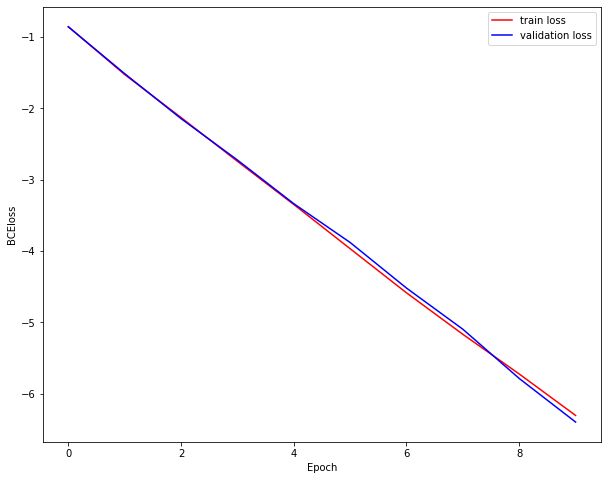

In [0]:
plt.figure(figsize=(10,8))
plt.xlabel('Epoch')
plt.ylabel('BCEloss')
plt.plot(train_loss,'r', label='train loss' )
plt.plot(validation_loss,'b',label='validation loss')
plt.legend()

##Compute of the MSE##

Display of 5 random images and the ouput of the model

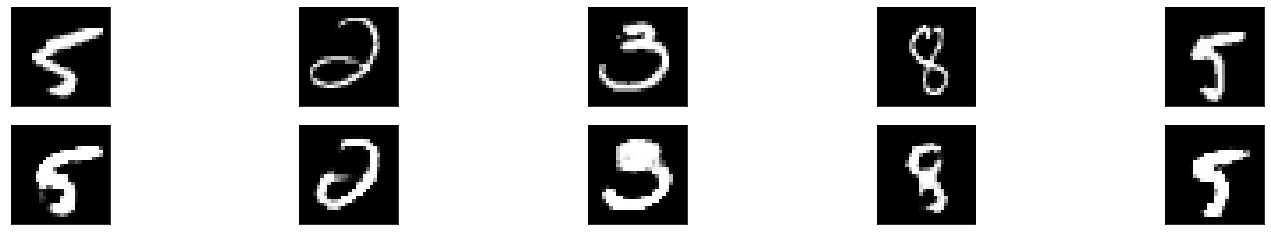

In [0]:
#take 5 random images
random_set_loader = torch.utils.data.DataLoader(
     mnist_testset,
    batch_size=5, 
    shuffle=True)
dataiter = iter(random_set_loader)
images,_ =dataiter.next()
images = images.cuda()
output = model(images)
images = images.cpu().detach().numpy()
output = output.cpu().detach().numpy()
fig, axes = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True,figsize=(25,4
))  
for images, row in zip([images, output],axes):
  for img,ax in zip(images,row):
    ax.imshow(np.squeeze(img), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

**Generate 5 new images**

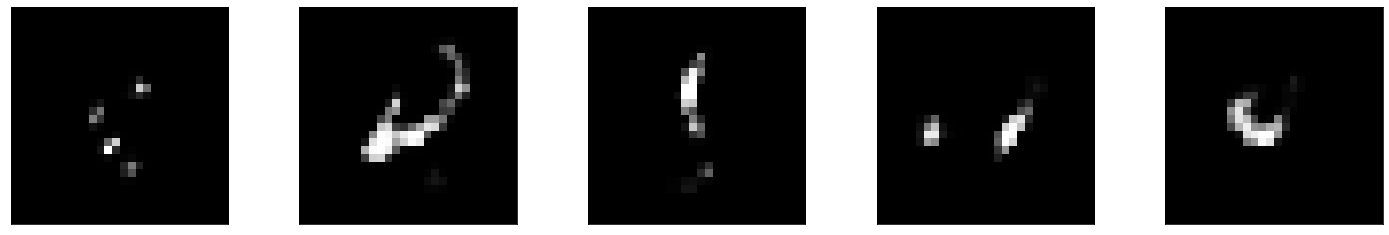

In [0]:
#for i in range(5):
nb_images = 5
rand_features = torch.randn(nb_images, bottleneck).to(hparams['device']) 
output = model.decoder(rand_features)
#Visualisation
output = output.cpu().detach().numpy()
images_width = 28
fig, axes = plt.subplots(nrows=1,ncols=5,sharex=True,sharey=True,figsize=(25,4))
decoded_images = output[:nb_images]  
for ax, img in zip(axes, decoded_images):
    ax.imshow(np.squeeze(img), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#Exercice 2#

We take a subset of 100 images and their associates label from the MNIST training data.

In [0]:
nb_images_subnet = 100
[trainset,_]=torch.utils.data.random_split(mnist_trainset,[nb_images_subnet,tvdataset_length-nb_images_subnet])
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

We first take the layers of the encoder part of the  model autoencoder. We take the one with a bottleneck of length 15.

In [0]:
encoder_pretrain = model.encoder 
encoder_pretrain.eval()
encoder_pretrain.to(hparams['device'])

Encoder(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Flatten()
  )
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=15, bias=True)
    (1): ReLU()
  )
)

We create the classification model

In [0]:
bottleneck = 15
class Classification(nn.Module):
  def __init__(self,endoder):
    super().__init__()
    self.layers = endoder
    #fully connected layers
    self.fc = nn.Sequential(
        nn.Linear(bottleneck,10),
        nn.Softmax(dim=1)
    )
  def forward(self,x):
    x = self.layers(x)
    x= self.fc(x)
    return x

Training with the previous weights. 

In [1]:
model_classifier = Classification(encoder_pretrain)
for layer in list(model_classifier.layers):
  for param in layer.parameters():
    param.require_grad = False    #Freeze layers of the encoder

NameError: ignored

In [0]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train_epoch(train_loader, network, optimizer, criterion, hparams):
  # Activate the train=True flag inside the model
  network.train()
  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model_classifier(data)
      loss = criterion(output, target)
      loss.backward()
      if avg_loss:
        avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
      else:
        avg_loss = loss.item()
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return avg_loss
def test_epoch(test_loader, network, hparams):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model_classifier(data)
            test_loss += criterion(output, target, reduction='sum').item() # sum up batch loss
            # compute number of correct predictions in the batch
            acc += correct_predictions(output, target)
    # Average acc across all correct predictions batches now
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, acc, len(test_loader.dataset), test_acc,
        ))
    return test_loss, test_acc

In [0]:
tr_losses = []
te_losses = []
te_accs = []
model_classifier.to(hparams['device'])
optimizer = optim.RMSprop(model_classifier.parameters(), lr=hparams['learning_rate'])
criterion = F.nll_loss

for epoch in range(1, hparams['num_epochs'] + 50):
  tr_losses.append(train_epoch(train_loader, model_classifier, optimizer, criterion, hparams))
  te_loss, te_acc = test_epoch(test_loader, model_classifier, hparams)
  te_losses.append(te_loss)
  te_accs.append(te_acc)

Train Epoch: 1 [0/100 (0%)]	Loss: -0.082447

Test set: Average loss: -0.1364, Accuracy: 1406/10000 (14%)

Train Epoch: 2 [0/100 (0%)]	Loss: -0.162588

Test set: Average loss: -0.2054, Accuracy: 2643/10000 (26%)

Train Epoch: 3 [0/100 (0%)]	Loss: -0.305485

Test set: Average loss: -0.2655, Accuracy: 3141/10000 (31%)

Train Epoch: 4 [0/100 (0%)]	Loss: -0.318949

Test set: Average loss: -0.3018, Accuracy: 3385/10000 (34%)

Train Epoch: 5 [0/100 (0%)]	Loss: -0.443720

Test set: Average loss: -0.3218, Accuracy: 3614/10000 (36%)

Train Epoch: 6 [0/100 (0%)]	Loss: -0.442210

Test set: Average loss: -0.3453, Accuracy: 3846/10000 (38%)

Train Epoch: 7 [0/100 (0%)]	Loss: -0.528384

Test set: Average loss: -0.3606, Accuracy: 3935/10000 (39%)

Train Epoch: 8 [0/100 (0%)]	Loss: -0.520575

Test set: Average loss: -0.3625, Accuracy: 3909/10000 (39%)

Train Epoch: 9 [0/100 (0%)]	Loss: -0.528279

Test set: Average loss: -0.3745, Accuracy: 4065/10000 (41%)

Train Epoch: 10 [0/100 (0%)]	Loss: -0.536959

